---
title: Time domain cyl forward
description: ''
short_title: ''
authors:
  - userId: uGKcpSd8C8Ngzg9FusKDcQp0kIb2
    nameParsed:
      literal: Lindsey Heagy
      given: Lindsey
      family: Heagy
    name: Lindsey Heagy
    orcid: 0000-0002-1551-5926
    corresponding: false
    roles: []
    affiliations: []
    id: contributors-generated-uid-0
date: '2022-06-16T18:19:48.450Z'
name: time-domain-cyl-forward
venue: Notebooks
binder: >-
  https://mybinder.org/v2/gh/geoscixyz/inversion-module/HEAD?filepath=time-domain-cyl-forward.ipynb
oxa: oxa:VNMrkxzChhdveZyf6lmb/0aIfyFPX2GGuY6apCgcB
tags: []
keywords: []
thumbnail: thumbnails/time-domain-cyl-forward.png
---

# Forward simulation of TDEM on cylindrical meshes with SimPEG

In this notebook, we demonstrate a time domain electromagnetic simulation using SimPEG. We use a cylindrically symmetric mesh and simulate a sounding over a sphere in a halfspace.

In [1]:
# packages from the python ecosystem 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import ipywidgets
from scipy.constants import mu_0

# software from the SimPEG ecosystem
import discretize
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as tdem
from pymatsolver import Pardiso

In [2]:
# set a bigger font size
from matplotlib import rcParams
rcParams["font.size"]=14

## Define model parameters

In [3]:
# electrical conductivities in S/m
sig_halfspace = 1e-3
sig_sphere = 1e-1
sig_air = 1e-8

In [4]:
# depth to center, radius in m
sphere_z = -50.
sphere_radius = 30.

## Survey parameters

In [5]:
# coincident source-receiver
src_height = 30.  
rx_offset = 0.

# times when the receiver will sample db/dt
times = np.logspace(-6, -3, 30)

# source and receiver location in 3D space
src_loc = np.r_[0., 0., src_height]
rx_loc = np.atleast_2d(np.r_[rx_offset, 0., src_height])

In [6]:
# print the min and max diffusion distances to make sure mesh is 
# fine enough and extends far enough 

def diffusion_distance(sigma, time):
    return 1.28*np.sqrt(time/(sigma * mu_0))

print(f'max diffusion distance: {diffusion_distance(sig_halfspace, times.max()):0.2e} m')

max diffusion distance: 1.14e+03 m


## Create a mesh

Up until now, we have just been working with standard python libraries. Now, we will create a cylindrically symmetric mesh on which we will perform the simulation. Note that for an EM experiment, we need the mesh to extend sufficiently far (well beyond the diffusion distance) to ensure the boundary condutions are satisfied

In [7]:
# x-direction
csx = 1  # core mesh cell width in the x-direction
ncx = np.ceil(2*sphere_radius/csx)  # number of core x-cells
npadx = 25  # number of x padding cells

# z-direction
csz = 1  # core mesh cell width in the z-direction
ncz = np.ceil(2*(src_height - (sphere_z-sphere_radius))/csz) # number of core z-cells
npadz = 25  # number of z padding cells

# padding factor (expand cells to infinity)
pf = 1.3

22950


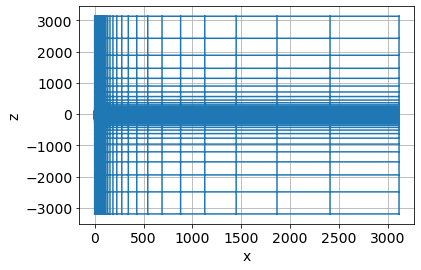

In [8]:
# cell spacings in the x and z directions
hx = discretize.utils.unpack_widths([(csx, ncx), (csx, npadx, pf)])
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# define a mesh
mesh = discretize.CylMesh([hx, 1, hz], origin=np.r_[0.,0., -hz.sum()/2.-src_height])
mesh.plot_grid();
print(mesh.nC)

## put the model on the mesh

In [9]:
# create a vector that has one entry for every cell center
sigma = sig_air*np.ones(mesh.nC)  # start by defining the conductivity of the air everwhere
sigma[mesh.gridCC[:,2] < 0.] = sig_halfspace  # assign halfspace cells below the earth

sigma_background = sigma.copy()

# indices of the sphere (where (x-x0)**2 + (z-z0)**2 <= R**2)
sphere_ind = (mesh.gridCC[:,0]**2 + (mesh.gridCC[:,2] - sphere_z)**2) <= sphere_radius**2 
sigma[sphere_ind] = sig_sphere  # assign the conductivity of the sphere

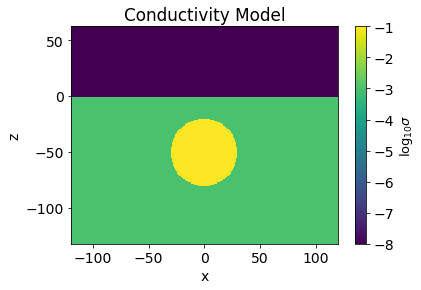

In [10]:
fig, ax = plt.subplots(1,1)
cb = plt.colorbar(mesh.plotImage(np.log10(sigma), ax=ax, mirror=True)[0])

# plot formatting and titles
cb.set_label('$\log_{10}\sigma$', fontsize=13)
ax.axis('equal')
ax.set_xlim([-120., 120.])
ax.set_ylim([-100., 30.])
ax.set_title('Conductivity Model');

## create the survey

A SimPEG survey needs to know about the sources and receivers. First, we define the receivers (in this case, a single $\partial \vec{b} / \partial t$ receiver that is coincident with the source.)

In [11]:
# Define the receivers
dbdt_z = tdem.receivers.Point_dbdt(locs=rx_loc, times=times, orientation='z')  # vertical db_dt

In [12]:
# Define the list of sources - one source for each frequency. The source is a point dipole oriented
# in the z-direction

source_list = [
    tdem.sources.CircularLoop(
        receiver_list=[dbdt_z], radius=1, location=src_loc, orientation='z', waveform=tdem.sources.StepOffWaveform()
    )
]

survey = tdem.Survey(source_list)

## set up a simulation

In [13]:
# solve the problem at these times
nsteps = 20
dt_list = [1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4]
time_steps = [(dt, nsteps) for dt in dt_list] 

simulation = tdem.Simulation3DElectricField(
    mesh, time_steps=time_steps, survey=survey,
    solver=Pardiso, sigmaMap=maps.IdentityMap(mesh)
) 

In [14]:
%%time
print('solving with sphere ... ')
fields = simulation.fields(sigma)
print('... done ')

solving with sphere ... 
... done 
CPU times: user 19.1 s, sys: 946 ms, total: 20.1 s
Wall time: 5.28 s


In [15]:
%%time
print('solving without sphere ... ')
fields_background = simulation.fields(sigma_background)
print('... done ')

solving without sphere ... 
... done 
CPU times: user 18.6 s, sys: 871 ms, total: 19.5 s
Wall time: 5.04 s


### define some utility functions for plotting 

In [24]:
def plot_field(model="background", view="dbdt", time_ind=1, ax=None):
    min_field, max_field = None, None
    vType = "CC"
    view_type="real"
    mirror_data=None
    
    if ax is None: 
        fig, ax = plt.subplots(1,1, figsize=(8,5))
        
    if view in ["j", "dbdt"]:
        if model == "background":
            plotme = fields_background[source_list, view, time_ind]
        else:
            plotme = fields[source_list, view, time_ind]
        max_field = np.abs(plotme).max() #use to set colorbar limits
        
        if view == "dbdt":
            vType, view_type="F", "vec"
            cb_range = 5e2  # dynamic range of colorbar
            min_field = max_field/cb_range
            norm=LogNorm(vmin=min_field, vmax=max_field)
        elif view == "j":
            plotme = mesh.average_edge_y_to_cell * plotme
            mirror_data = -plotme
            norm=Normalize(vmin=-max_field, vmax=max_field)
    else:
        label = "$\sigma$"
        norm=LogNorm(vmin=sig_air, vmax=np.max([sig_sphere, sig_halfspace]))
        if model == "background":
            plotme = sigma_background
        else:
            plotme = sigma
    
    cb = plt.colorbar(mesh.plotImage(
        plotme, 
        vType=vType, view=view_type, mirror_data=mirror_data,
        range_x=[-150., 150.], range_y=[-150., 70.],
        pcolorOpts={'norm': norm}, streamOpts={'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax,
    )[0], ax=ax)
    cb.set_label(view) 

    
def plot_sphere_outline(ax):
    x = np.linspace(-sphere_radius, sphere_radius, 100)
    ax.plot(x, np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k', alpha=0.5, lw=0.5)
    ax.plot(x, -np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k', alpha=0.5, lw=0.5)


In [22]:
def plot_fields_sphere(model="background", view="dbdt", time_ind=1): 
    fig, ax = plt.subplots(1,1, figsize=(8,5))

    plot_field(model, view, time_ind, ax)
     # plot the outline of the sphere
    if model == "sphere":
        plot_sphere_outline(ax)

    # plot the source locations and earth surface
    ax.plot(src_loc[0],src_loc[2],'C1o', markersize=6)
    ax.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')

    # give it a title
    ax.set_title(f'{view}, {simulation.times[time_ind]*1e3:10.2e} ms')
    ax.set_aspect(1)

#     return ax

## View the simulated fields

In [26]:
ipywidgets.interact(
    plot_fields_sphere, 
    model=ipywidgets.ToggleButtons(options=["background", "sphere"], value="background"),
    view=ipywidgets.ToggleButtons(options=["model", "j", "dbdt"], value="model"),
    time_ind=ipywidgets.IntSlider(min=1, max=len(simulation.time_steps)-1, value=1, continuous_update=False), 
);

interactive(children=(ToggleButtons(description='model', options=('background', 'sphere'), value='background')…

## predicted data

In [19]:
dpred = simulation.dpred(sigma, f=fields)
dpred_background = simulation.dpred(sigma_background, f=fields_background)

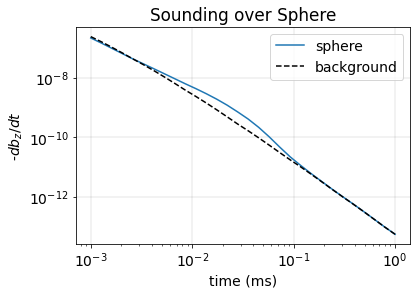

In [20]:
# Plot
fig, ax = plt.subplots(1,1)

ax.loglog(1e3*times, -dpred, label="sphere")
ax.loglog(1e3*times, -dpred_background, '--k', label="background")
ax.grid(True, color='k',linestyle="-", linewidth=0.1)
ax.legend()

ax.set_title('Sounding over Sphere')
ax.set_ylabel('-$db_z/dt$')
ax.set_xlabel('time (ms)');